# Proyek Klasifikasi Gambar: Animal Image Classification Dataset
- **Nama:** Yoga Samudra
- **Email:** 08samudra@gmail.com
- **ID Dicoding:** 08samudra

## Import Semua Packages/Library yang Digunakan

In [34]:
import os
import numpy as np
import shutil
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from PIL import Image

## Load Datasets

### Menggunakan Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Memilih Path pada Folder MyDrive
Note: Jika tidak menggunakan Google Drive bisa disesuaikan Path nya.

In [4]:
dataset_path = "/content/drive/MyDrive/Dicoding_Submission/datasets"
print(os.listdir(dataset_path))  # Cek apakah file/folder muncul

['cats', 'snakes', 'dogs']


##

### Menampilkan jumlah Data pada Folder

In [5]:
dataset_path = "/content/drive/MyDrive/Dicoding_Submission/datasets"
categories = ['cats', 'snakes', 'dogs']

for category in categories:
    category_path = os.path.join(dataset_path, category)
    print(f"{category}: {len(os.listdir(category_path))} gambar")

cats: 1000 gambar
snakes: 1000 gambar
dogs: 1010 gambar


## Membagi Datsets Menjadi Train, Test, & Validation

In [6]:
# Membuat direktori baru untuk train, test, dan validation
base_dir = "/content/split_datasets"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "validation")

for folder in [train_dir, test_dir, val_dir]:
    os.makedirs(folder, exist_ok=True)
    for category in categories:
        os.makedirs(os.path.join(folder, category), exist_ok=True)

# Pisahkan dataset menjadi Train (80%), Validation (10%), dan Test (10%)
for category in categories:
    category_path = os.path.join(dataset_path, category)
    images = np.array(os.listdir(category_path))

    # Pisahkan train dan sisanya (validation + test)
    train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)

    # Pisahkan validation dan test dari sisanya
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Copy file ke masing-masing direktori
    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category))

    for img in val_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category))

    for img in test_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category))

print("Pembagian dataset selesai: Train, Validation, dan Test Set sudah terpisah!")

Pembagian dataset selesai: Train, Validation, dan Test Set sudah terpisah!


### Visualisasi Gambar Awal Setelah Split Dataset

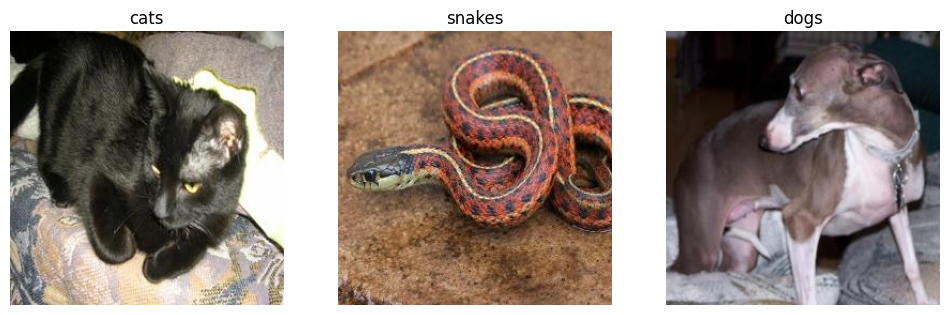

In [9]:
# Path Train Set setelah Split Dataset
train_dir = "/content/split_datasets/train"
categories = ['cats', 'snakes', 'dogs']

# Fungsi untuk menampilkan gambar awal
def show_sample_images():
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for i, category in enumerate(categories):
        category_path = os.path.join(train_dir, category)
        sample_image = random.choice(os.listdir(category_path))  # Pilih gambar acak
        img = Image.open(os.path.join(category_path, sample_image))

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(category)

    plt.show()

# Panggil fungsi untuk menampilkan gambar
show_sample_images()

## Preprocessing & Augmentasi Dataset

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,  # Meningkatkan rotasi gambar
    zoom_range=0.3,  # Memperbesar zoom untuk variasi fitur
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]  # Variasi pencahayaan
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory("/content/split_datasets/train", target_size=(224, 224), batch_size=32, class_mode="categorical")
val_generator = val_test_datagen.flow_from_directory("/content/split_datasets/validation", target_size=(224, 224), batch_size=32, class_mode="categorical")
test_generator = val_test_datagen.flow_from_directory("/content/split_datasets/test", target_size=(224, 224), batch_size=32, class_mode="categorical")

Found 2408 images belonging to 3 classes.
Found 301 images belonging to 3 classes.
Found 301 images belonging to 3 classes.


## Membangun Model CNN (Dengan Transfer Learning)

In [11]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Bekukan lapisan pre-trained

# Model CNN dengan tambahan Conv2D dan Pooling Layer
model = Sequential([
    base_model,
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.4),
    Dense(3, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Training dengan Early Stopping

In [13]:
history = model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
])

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.8947 - loss: 0.2965 - val_accuracy: 0.9834 - val_loss: 0.0637
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9357 - loss: 0.1747 - val_accuracy: 0.9767 - val_loss: 0.0585
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9538 - loss: 0.1488 - val_accuracy: 0.9668 - val_loss: 0.0865
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9624 - loss: 0.0923 - val_accuracy: 0.9734 - val_loss: 0.0694
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9661 - loss: 0.0952 - val_accuracy: 0.9801 - val_loss: 0.0640
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9645 - loss: 0.0948 - val_accuracy: 0.9767 - val_loss: 0.0691
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9711 - loss: 0.0763 - val_accuracy: 0.9734 - val_loss: 0.0637


## Evaluasi Model di Test Set

In [14]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Akurasi Model pada Test Set: {test_acc*100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9688 - loss: 0.1075
Akurasi Model pada Test Set: 97.01%


## Visualisasi Performa Model

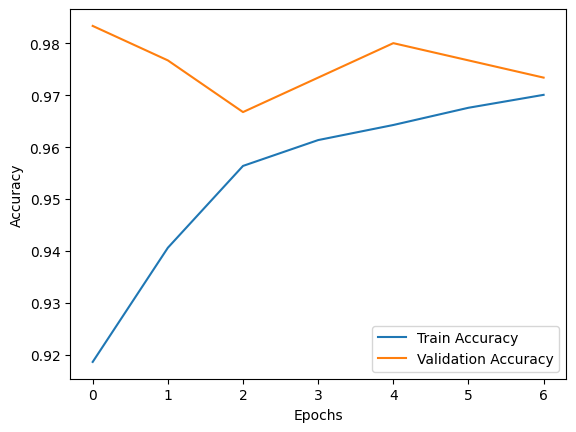

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Visualisasi Plot Akurasi & Loss

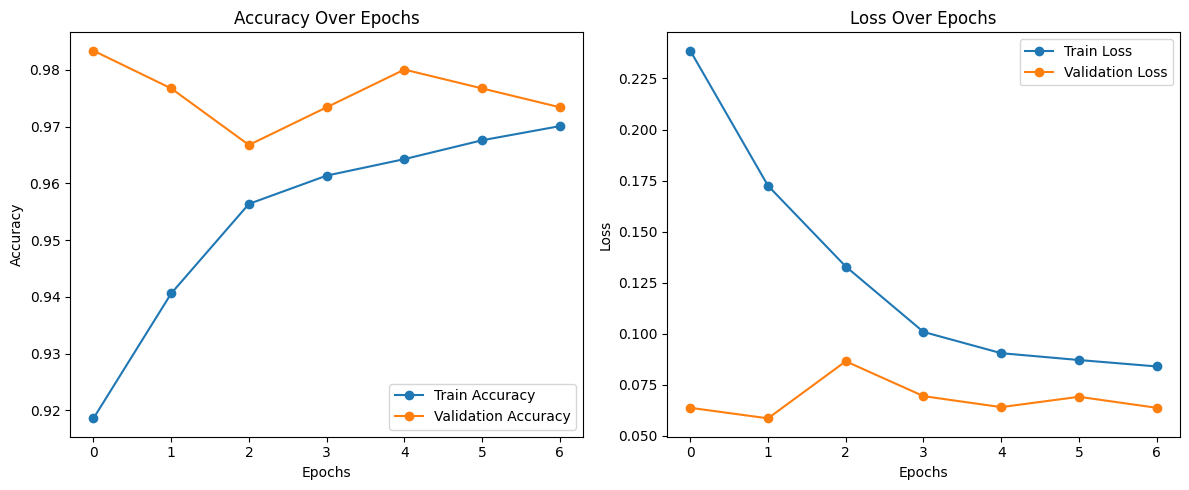

In [32]:
# Plot Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy", marker="o")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss", marker="o")
plt.plot(history.history["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")

plt.tight_layout()
plt.show()

### Tabel Akurasi & Loss

In [35]:
# Membuat DataFrame untuk akurasi dan loss
epochs = range(1, len(history.history["accuracy"]) + 1)
data = {
    "Epoch": epochs,
    "Train Accuracy": history.history["accuracy"],
    "Validation Accuracy": history.history["val_accuracy"],
    "Train Loss": history.history["loss"],
    "Validation Loss": history.history["val_loss"]
}

df = pd.DataFrame(data)

# Menampilkan tabel
print(df)

   Epoch  Train Accuracy  Validation Accuracy  Train Loss  Validation Loss
0      1        0.918605             0.983389    0.238607         0.063692
1      2        0.940615             0.976744    0.172459         0.058534
2      3        0.956395             0.966777    0.132905         0.086475
3      4        0.961379             0.973422    0.100863         0.069408
4      5        0.964286             0.980066    0.090447         0.064025
5      6        0.967608             0.976744    0.087101         0.069091
6      7        0.970100             0.973422    0.083955         0.063698


## Visualisasi Prediksi Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


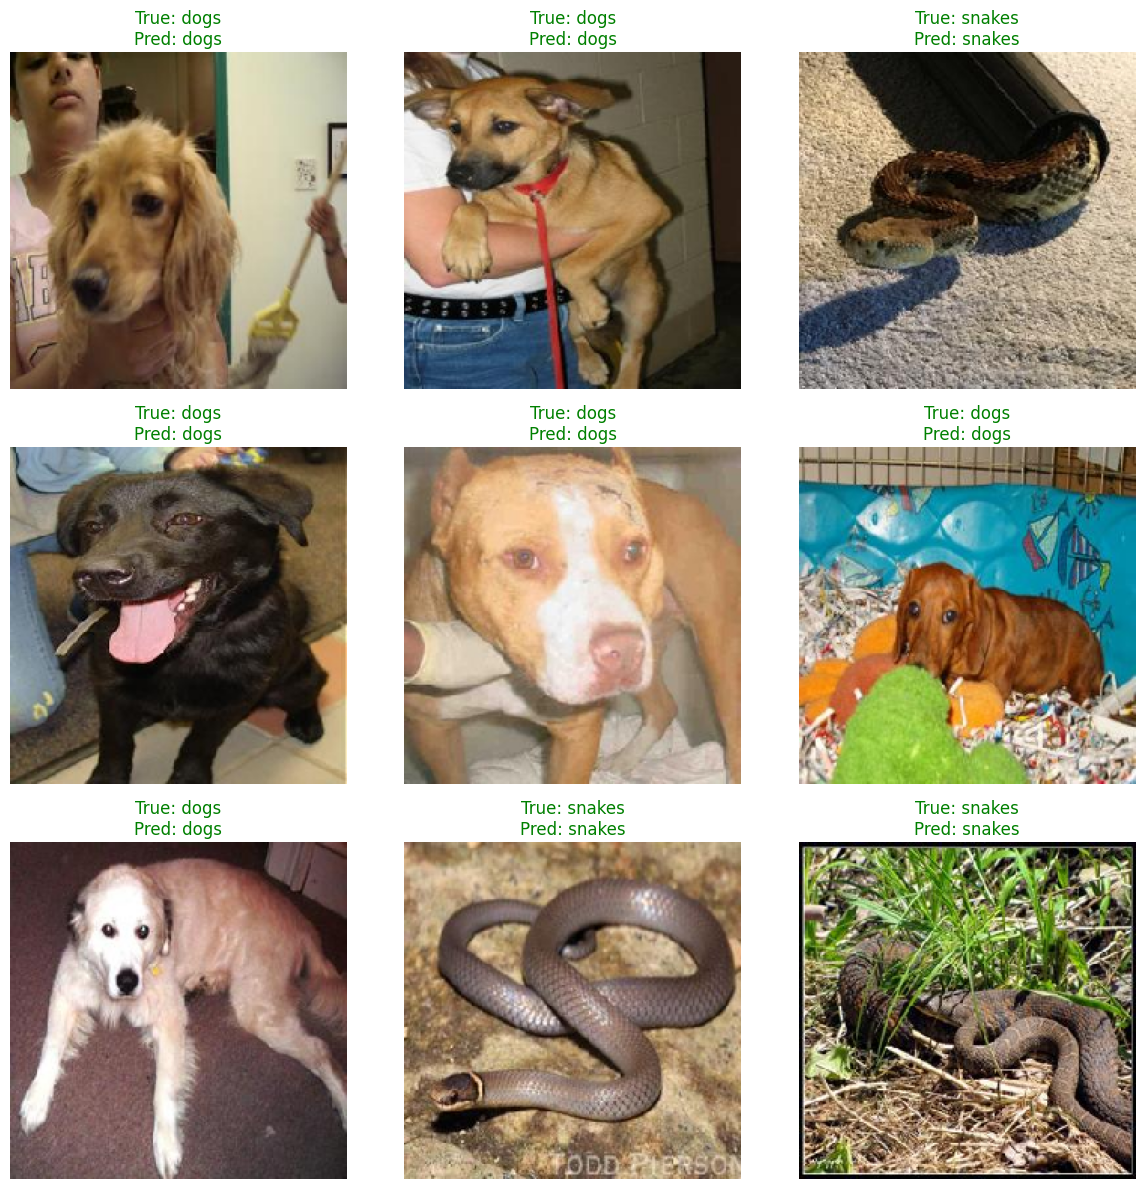

In [17]:
# Ambil batch gambar dari Test Set
test_images, test_labels = next(test_generator)

# Lakukan prediksi
predictions = model.predict(test_images)

# Ambil kelas yang memiliki probabilitas tertinggi
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Mapping label kelas
class_labels = list(test_generator.class_indices.keys())

# Visualisasi hasil prediksi
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    img = test_images[i]
    true_label = class_labels[true_classes[i]]
    predicted_label = class_labels[predicted_classes[i]]

    # Warna hijau jika prediksi benar, merah jika salah
    color = "green" if true_label == predicted_label else "red"

    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color=color)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Konversi Model

### SavedModel

In [19]:
# Simpan ke folder 'saved_model'
tf.saved_model.save(model, 'saved_model')

### TF-Lite

In [25]:
# TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)



In [26]:
# Ambil daftar kelas dari train_generator
class_names = list(train_generator.class_indices.keys())

# Simpan ke label.txt
with open("tflite/label.txt", "w") as f:
    for label in class_names:
        f.write(label + "\n")

print("Label telah disimpan ke tflite/label.txt!")

Label telah disimpan ke tflite/label.txt!


### TFJS

In [ ]:
# TFJS
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model